In [1]:
# Importing necessary module
import numpy as np
import PIL
import matplotlib.pyplot as plt

In [4]:
isri = 'isri_5g.gif'
skull = 'skull.gif'

def connected_component(path, connectivity='n4'):
    
    def load_image(path):
        """
        Convert and image to an numpy array.
        It will return the padded image.
        Each axis will be padded with zero
        """
        img = np.asarray(PIL.Image.open(path))
        if np.max(img) > 1:
            # it's not a binary image
            # conver the image into binary
            img = np.where(img < 128, 0, img)
            img = np.where(img >= 128, 1, img)
        return img
    
    def get_connected_component_n4(img):
        label = 0
        padded_img = np.pad(img, (1, 0), mode='constant', constant_values=(0, 0))
        connected_component = np.zeros(padded_img.shape).astype(int)
        for row in range(1, padded_img.shape[0]):
            for col in range(1, padded_img.shape[1]):
                if padded_img[row, col] == 0:
                    continue
                # Check it's neighbour
                top = connected_component[row-1, col]
                left = connected_component[row, col-1]
                if top == 0 and left == 0:
                    # Set new label
                    label += 1
                    put_label = label
                elif top == left:
                    put_label = top
                else:
                    # Top and the left label doesn't match
                    if top != 0 and left != 0:
                        put_label = min(top, left)
                        # Backtrack the array to replace the updated label
                        will_replace = top if left == label else left
                        # we will seach for will_replace and replace it with the label
                        connected_component = np.where(connected_component == will_replace, put_label, connected_component)
                    elif top == 0:
                        put_label = left
                    else:
                        put_label = top
                connected_component[row, col] = put_label
        return connected_component[1:, 1:]
    
    def get_connected_component_n8(img):
        label = 0
        padded_img = np.pad(img, (1, 1), mode='constant', constant_values=(0, 0))
        connected_component = np.zeros(padded_img.shape).astype(int)
        for row in range(1, padded_img.shape[0]):
            for col in range(1, padded_img.shape[1]):
                if padded_img[row, col] == 0:
                    continue
                # Check it's neighbour
                top = connected_component[row-1, col]
                left = connected_component[row, col-1]
                top_left = connected_component[row-1, col-1]
                top_right = connected_component[row-1, col+1]
                neighbours = [top, left, top_right, top_left]
                if top == left == top_left == top_right == 0:
                    # Set new label
                    label += 1
                    put_label = label
                elif (left == top == 0 and top_left != 0 and top_right != 0) or \
                    (top_left == top == 0 and left != 0 and top_right != 0) or \
                    (top == 0 and left != 0 and top_left != 0 and top_right != 0):
                    put_label = min(neighbours)
                    for val in neighbours:
                        connected_component = np.where(connected_component == val, put_label, connected_component)
                else:
                    put_label = min(neighbours)

                connected_component[row, col] = put_label
        return connected_component[1:-1, 1:-1]
        
    
    def bounding_box_on_connected_component(connected_component):
        connected_component = np.pad(connected_component, (1, 1), mode='constant', constant_values=(0, 0))
        # draw bounding boxes on connected component
        bb_connected_component = np.zeros(connected_component.shape).astype(int)
        # add padding
        print(bb_connected_component.shape)
        for row in range(1, bb_connected_component.shape[0]):
            for col in range(1, bb_connected_component.shape[1]):
                if connected_component[row, col] != 0:
                    # check top
                    bb_connected_component[row-1, col] = 1 if connected_component[row-1, col] == 0 else 0
                    # check bottom
                    bb_connected_component[row+1, col] = 1 if connected_component[row+1, col] == 0 else 0
                    # check left
                    bb_connected_component[row, col-1] = 1 if connected_component[row, col-1] == 0 else 0
                    # check right
                    bb_connected_component[row, col+1] = 1 if connected_component[row, col+1] == 0 else 0
                    # check top left
                    bb_connected_component[row-1, col-1] = 1 if connected_component[row-1, col-1] == 0 else 0
                    # check top right
                    bb_connected_component[row-1, col+1] = 1 if connected_component[row-1, col+1] == 0 else 0
                    # check bottom left
                    bb_connected_component[row+1, col-1] = 1 if connected_component[row+1, col-1] == 0 else 0
                    # check bottom right
                    bb_connected_component[row+1, col+1] = 1 if connected_component[row+1, col+1] == 0 else 0

        return bb_connected_component[1:-1, 1:-1]
    
    if connectivity == 'n8':
        connected_comp = get_connected_component_n8(load_image(path))
    else:
        connected_comp = get_connected_component_n4(load_image(path))
    print(f"Total number of connected component in the image: {str(np.unique(np.ravel(connected_comp)).shape[0])}")
    plt.title("Bounding boxes on the connected component")
    plt.imshow(bounding_box_on_connected_component(connected_comp), cmap='gray_r')
    plt.show()

Total number of connected component in the image: 92


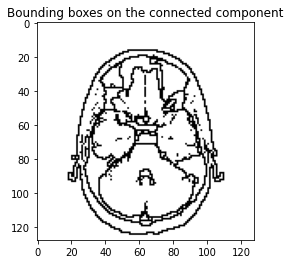

In [154]:
connected_component(skull)

Total number of connected component in the image: 203


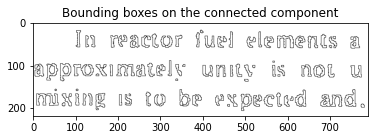

In [155]:
connected_component(isri)

Total number of connected component in the image: 383
(130, 130)


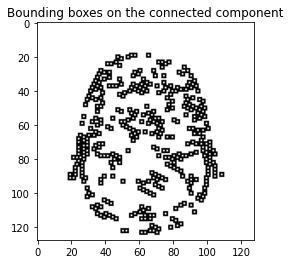

In [160]:
connected_component(skull, 'n8')

Total number of connected component in the image: 1296
(221, 792)


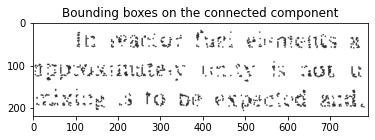

In [162]:
connected_component(isri, 'n8')

In [16]:
import cv2
import os
def connected_component_label(path):
    
    # Getting the input image
    path = os.path.join(os.getcwd(), path)
    img = cv2.imread(path, 0)
    # Converting those pixels with values 1-127 to 0 and others to 1
    img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]
    # Applying cv2.connectedComponents() 
    num_labels, labels = cv2.connectedComponents(img, connectivity = 4)
    print(num_labels)
    print(labels)
    
    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    
    
    # Showing Original Image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Orginal Image")
    plt.show()
    
    #Showing Image after Component Labeling
    plt.imshow(cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Image after Component Labeling")
    plt.show()

49
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


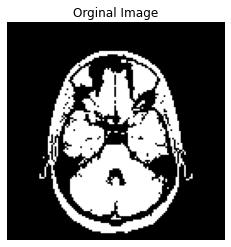

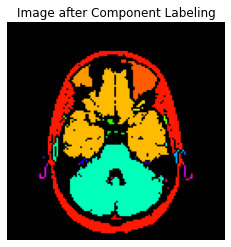

In [17]:
connected_component_label('skull.jpg')

In [9]:
a = cv2.VideoCapture(skull)
a

<VideoCapture 0x12ba0a910>